In [189]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [190]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The code for this notebook is hidden for easier reading.
To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

# Questions for Debjit: 

<span class="burk">1.  Why did the initial data preparation drill suggest that 'murder' and 'robbery' be recoded as categorical features? Does this choice impact the assumptions and model outcomes?
<span class="burk">2.  Are all 4 assumptions equally weighted? If not, which are prioritized and why? Must I always attempt to fix violated assumptions and if so, how far can I go before I'm over-engineering features?</span> 
<span class="burk">3.  When evaluating a model using holdout groups and/or cross-validation, should I check assumptions for the testing dataset as well? Why or why not?</span></span> 

# Cleaning & Feature Engineering

**Data: Crime In New York - [2013](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv).**

**I created a dataframe to hold the following features and the target variable - property crime:** 
-  'population' (Continuous)
-  'population_squared' (Continuous)
-  'murder' (Continuous - Formerly Categorical)
-  'robbery' (Continuous - Formerly Categorical)

In [191]:
path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime = pd.read_csv(path)

In [192]:
pd.options.mode.chained_assignment = None

crime.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']
crime.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)

pcmodel = crime[['murder','population','property_crime','robbery']]
columns = list(pcmodel.columns)
for column in columns:
    pcmodel[column]=pcmodel[column].str.replace(',','')
    
pcmodel = pcmodel.apply(pd.to_numeric)
pcmodel['population_squared'] = pcmodel['population']**2

#Categorical coding that I decided against for my own model - it caused downstream cross-validation issues. 
# pcmodel['murder'] = pcmodel['murder'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
# pcmodel['robbery'] = pcmodel['robbery'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')

pcmodel.dropna(axis=0,how='all',inplace=True)
pcmodel.head()

,murder,population,property_crime,robbery,population_squared
4,0,1861,12,0,3463321
5,0,2577,24,0,6640929
6,0,2846,16,0,8099716
7,8,97956,4090,227,9595377936
8,0,6388,223,4,40806544


In [193]:
pcmodel.describe()

,murder,population,property_crime,robbery,population_squared
count,348.000000,3.480000e+02,348.000000,348.000000,3.480000e+02
mean,1.566092,4.003763e+04,792.606322,72.902299,2.035547e+11
std,18.303673,4.500374e+05,7659.724746,1031.032873,3.778876e+12
min,0.000000,5.260000e+02,0.000000,0.000000,2.766760e+05
25%,0.000000,3.003000e+03,40.500000,0.000000,9.018117e+06
50%,0.000000,7.233500e+03,112.500000,1.000000,5.232568e+07
75%,0.000000,1.842750e+04,341.000000,5.000000,3.397536e+08
max,335.000000,8.396126e+06,141971.000000,19170.000000,7.049493e+13


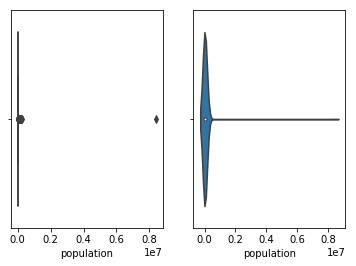

In [194]:
plt.subplot(121)
population = sns.boxplot(pcmodel['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel['population'])

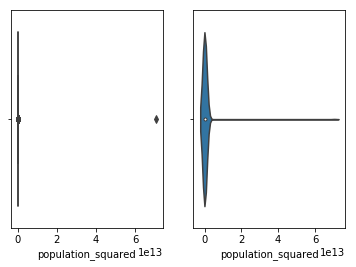

In [195]:
plt.subplot(121)
population_squared = sns.boxplot(pcmodel['population_squared'])
plt.subplot(122)
population = sns.violinplot(pcmodel['population_squared'])

**There are extreme outliers (much more densely populated cities) beyond Q3+1.5IQR that I chose to exclude.**

In [196]:
columns = list(pcmodel[['population','population_squared']].columns)
for column in columns: 
    q25 = pcmodel[column].quantile(0.25)
    q75 = pcmodel[column].quantile(0.75)
    iqr = q75 - q25
    max = q75 + (iqr * 1.5)
    pcmodel=pcmodel.where(pcmodel[column] < max)

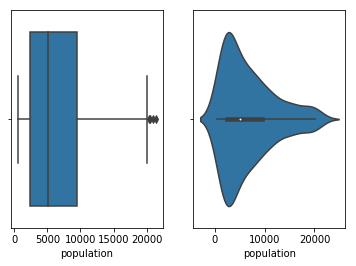

In [197]:
plt.subplot(121)
population = sns.boxplot(pcmodel['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel['population'])

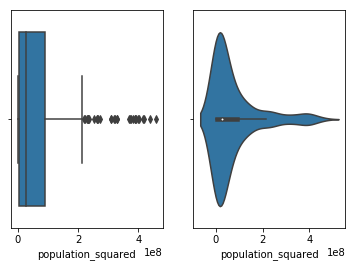

In [198]:
plt.subplot(121)
population_squared = sns.boxplot(pcmodel['population_squared'])
plt.subplot(122)
population_squared = sns.violinplot(pcmodel['population_squared'])

In [199]:
pcmodel.describe()

,murder,population,property_crime,robbery,population_squared
count,274.000000,274.000000,274.000000,274.000000,2.740000e+02
mean,0.051095,6730.492701,130.014599,1.777372,7.301594e+07
std,0.220594,5274.271168,151.249060,3.279093,1.039372e+08
min,0.000000,526.000000,0.000000,0.000000,2.766760e+05
25%,0.000000,2467.750000,31.000000,0.000000,6.089970e+06
50%,0.000000,5133.500000,73.500000,0.500000,2.635293e+07
75%,0.000000,9517.000000,171.000000,2.000000,9.057329e+07
max,1.000000,21397.000000,949.000000,24.000000,4.578316e+08


# Initial Model

In [200]:
pcmodel = pcmodel.dropna()
Y1 = pcmodel['property_crime']
X1 = pcmodel[['murder','population','population_squared','robbery']]

In [201]:
regr = linear_model.LinearRegression()
regr.fit(X1, Y1)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X1, Y1))


Coefficients: 
 [ 1.32154967e+01  1.49400004e-02 -1.69838668e-07  2.29415628e+01]

Intercept: 
 0.4110236790127715

R-Squared:
0.642266595555286


In [202]:
lf = 'property_crime ~ population + population_squared + murder + robbery'
lm = smf.ols(formula=lf, data=pcmodel).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     120.7
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           7.86e-59
Time:                        22:20:29   Log-Likelihood:                -1622.6
No. Observations:                 274   AIC:                             3255.
Df Residuals:                     269   BIC:                             3273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4110     13

**Based on the overall model's F-test statistic and p-value, I concluded that it provides a better fit than the intercept-only model.**

**Based on the features' t-test statistics and p-values, 'population_squared' isn't a statistically significant feature of the model.** 

**Based on the warning citing "multicollinearity or other numerical problems", I decided to check all 4 assumptions before making feature engineering and model revision decisions.** 

# Checking Assumptions

## Linear Relationship

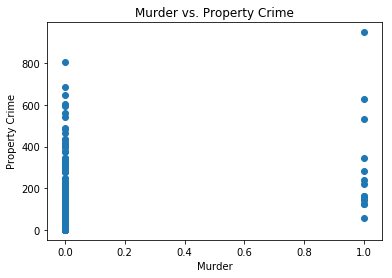

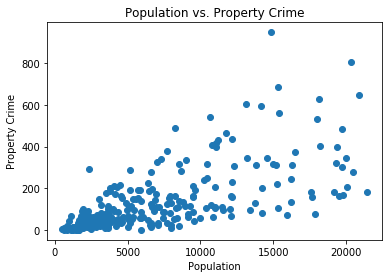

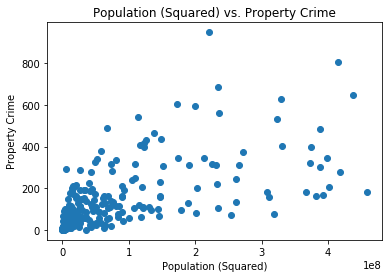

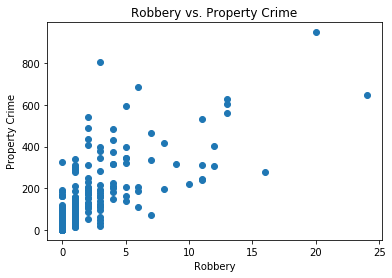

In [203]:
plt.scatter(y=pcmodel['property_crime'], x=pcmodel['murder'])
plt.ylabel('Property Crime')
plt.xlabel('Murder')
plt.title('Murder vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population_squared'])
plt.ylabel('Property Crime')
plt.xlabel('Population (Squared)')
plt.title('Population (Squared) vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

**The target 'property crime' seems to be less related to the features 'murder', 'robbery', and 'population_squared'.**

## Multivariate Normality

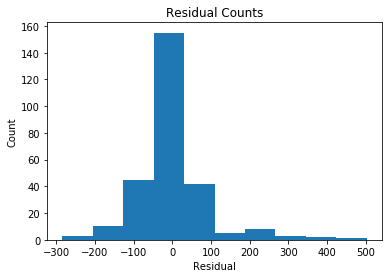

In [204]:
predicted = regr.predict(X1).ravel()
actual = Y1
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The model's error is approximately normal.**

## Homoscedasticity

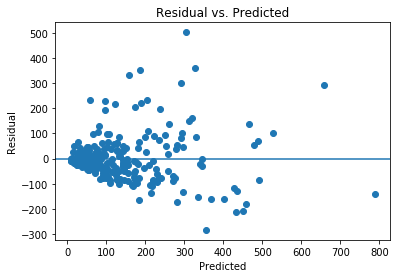

In [205]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**The error terms are heteroscedastic.**

## Low Multicollinearity

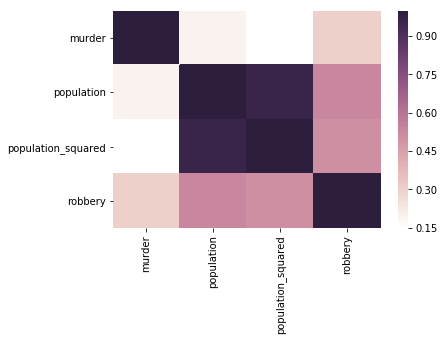

In [206]:
correlation_matrix = X1.corr()
multicollinearity = sns.heatmap(correlation_matrix,cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**Consistent with the initial model's warning, the feature 'population and its derivative 'population_squared' are highly correlated. There are moderate correlations between both of these features and 'robbery' as well.**

# Feature Reengineering

**Decisions:**
-  Added 'burglary' hypothesizing that it might improve the model's coefficient of determination (R^2). 
-  Added 'larceny_theft' hypothesizing that it might improve the model's coefficient of determination (R^2). 
-  Added 'vehicle_theft' hypothesizing that it might improve the model's coefficient of determination (R^2). 
-  Dropped 'murder' based on the initial model's summary statistics (p-value). 
-  Dropped 'population_squared' based on the initial model's summary statistics (p-value). 

In [207]:
pcmodel[['burglary','larceny_theft','vehicle_theft']]=crime[['burglary','larceny_theft','vehicle_theft']]
pcmodel.drop(labels=['murder','population_squared'], axis=1, inplace=True)

In [208]:

pcmodel.dropna(axis=0,how='all',inplace=True)
pcmodel = pcmodel.apply(pd.to_numeric)

#Categorical coding that I decided against for my own model - it caused downstream cross-validation issues. 
# pcmodel['burglary']=pcmodel['burglary'].apply(lambda x: 0 if x <= 0 else 1)
# pcmodel['larceny_theft']=pcmodel['larceny_theft'].apply(lambda x: 0 if x <= 0 else 1)
# pcmodel['vehicle_theft']=pcmodel['vehicle_theft'].apply(lambda x: 0 if x <= 0 else 1)

pcmodel.head()

,population,property_crime,robbery,burglary,larceny_theft,vehicle_theft
4,1861.0,12.0,0.0,2,10,0
5,2577.0,24.0,0.0,3,20,1
6,2846.0,16.0,0.0,1,15,0
8,6388.0,223.0,4.0,53,165,5
9,4089.0,46.0,3.0,10,36,0


# Revised Model 

In [219]:
Y2 = pcmodel['property_crime']
X2 = pcmodel[['burglary','larceny_theft','population','robbery','vehicle_theft']]

In [220]:
regr = linear_model.LinearRegression()
regr.fit(X2, Y2)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X2, Y2))


Coefficients: 
 [1.00000000e+00 1.00000000e+00 0.00000000e+00 3.53449908e-16
 1.00000000e+00]

Intercept: 
 1.9895196601282805e-13

R-Squared:
1.0


In [221]:
lf2 = 'property_crime ~ burglary + larceny_theft + population + robbery + vehicle_theft'
lm2 = smf.ols(formula=lf2, data=pcmodel).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.052e+29
Date:                Sun, 25 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:22:24   Log-Likelihood:                 7125.0
No. Observations:                 274   AIC:                        -1.424e+04
Df Residuals:                     268   BIC:                        -1.422e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.472e-13   1.24e-13     -2.001

**The model's coefficient of determination (R^2) is perfect compared the initial model's, according to the above regression score and summary - which is definitely cause for skepticism - there are likely too many features causing overfitting.**

**Based on the revised overall model's F-test statistic and p-value, I concluded that it still provides a better fit than the intercept-only model.**

**Based on the features' t-test statistics and p-values, 'robbery' isn't a statistically significant feature of the model.** 

**Based on the warning citing "multicollinearity or other numerical problems", I decided to re-check all 4 assumptions before making final feature engineering and model revision decisions.** 

# Re-Checking Assumptions

## Linear Relationship

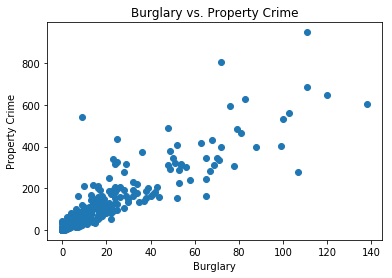

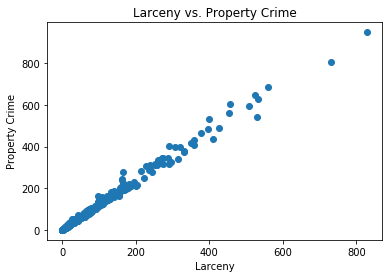

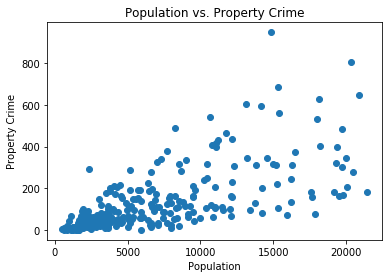

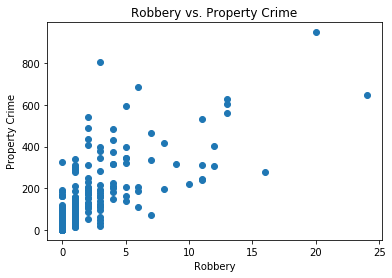

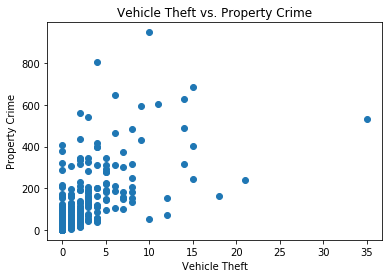

In [222]:
plt.scatter(y=pcmodel['property_crime'], x=pcmodel['burglary'])
plt.ylabel('Property Crime')
plt.xlabel('Burglary')
plt.title('Burglary vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['larceny_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Larceny')
plt.title('Larceny vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['vehicle_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Vehicle Theft')
plt.title('Vehicle Theft vs. Property Crime')
plt.show()

**There are linear relationship between these features and the target, but 'murder' seems to be less linearly related than 'burglary', 'larceny_theft', 'population, 'robbbery', and 'vehicle_theft' are to 'property_crime'.**

## Multivariate Normality

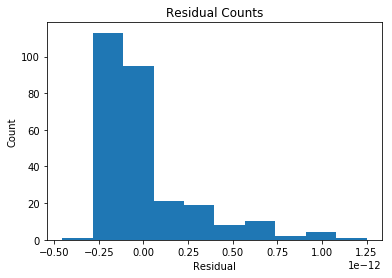

In [223]:
predicted = regr.predict(X2).ravel()
actual = Y2
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The model's error is less normally distributed than before.**

## Homoscedasticity

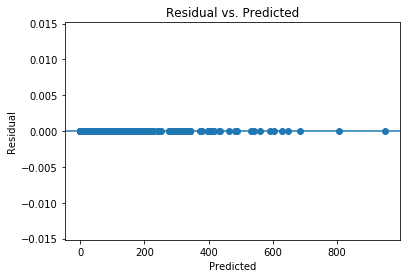

In [224]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**The error terms are homoscedastic, but unrealistically so.**

## Low Multicollinearity 

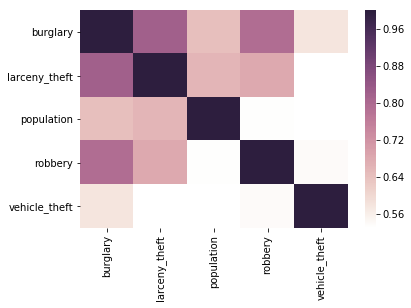

In [225]:
correlation_matrix = X2.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**There are significant interactions between 'burglary', larceny_theft', and 'robbery'. 'Population' is moderately collinear with the same features.**

# Final Model 

## Feature Finalization

**Decisions:**
-  Dropped 'robbery' based on the revised model's summary statistics (p-value). 

**Final Feature Set:**
-  'burglary'
-  'larceny_theft'
-  'population'
-  'robbery'
-  'vehicle_theft'

In [226]:
pcmodel = pcmodel[['burglary','larceny_theft','population','property_crime','robbery','vehicle_theft']]
pcmodel.head()

,burglary,larceny_theft,population,property_crime,robbery,vehicle_theft
4,2,10,1861.0,12.0,0.0,0
5,3,20,2577.0,24.0,0.0,1
6,1,15,2846.0,16.0,0.0,0
8,53,165,6388.0,223.0,4.0,5
9,10,36,4089.0,46.0,3.0,0


In [227]:
Y3 = pcmodel['property_crime']
X3 = pcmodel[['burglary','larceny_theft','population', 'vehicle_theft']]

In [228]:
regr = linear_model.LinearRegression()
regr.fit(X3, Y3)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [1. 1. 0. 1.]

Intercept: 
 -1.1937117960769683e-12

R-Squared:
1.0


In [230]:
lf3 = 'property_crime ~ burglary + larceny_theft + population + vehicle_theft'
lm3 = smf.ols(formula=lf3, data=pcmodel).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.137e+30
Date:                Sun, 25 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:32:55   Log-Likelihood:                 7141.2
No. Observations:                 274   AIC:                        -1.427e+04
Df Residuals:                     269   BIC:                        -1.425e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.304e-13   1.15e-13      1.134

## Final Assumptions Check 

### Linear Relationship

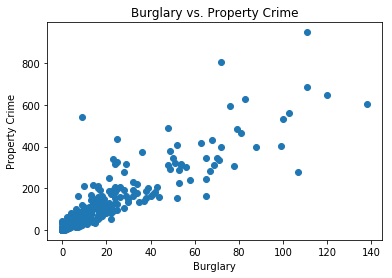

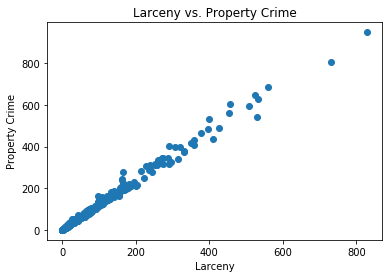

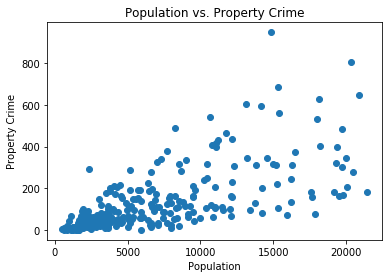

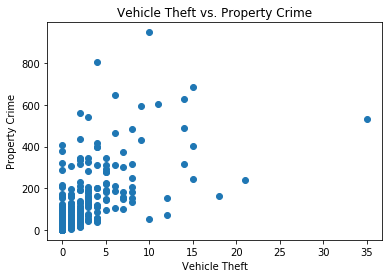

In [232]:
plt.scatter(y=pcmodel['property_crime'], x=pcmodel['burglary'])
plt.ylabel('Property Crime')
plt.xlabel('Burglary')
plt.title('Burglary vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['larceny_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Larceny')
plt.title('Larceny vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['vehicle_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Vehicle Theft')
plt.title('Vehicle Theft vs. Property Crime')
plt.show()

**There's still a linear relationship between these features and the target, and 'vehicle_theft' seems to be less linearly related than the others.**

### Multivariate Normality

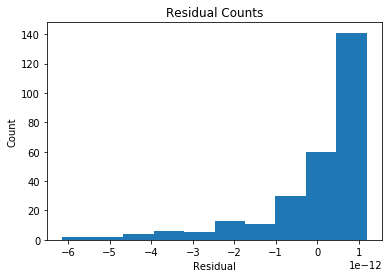

In [233]:
predicted = regr.predict(X3).ravel()
actual = Y3
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The model's error isn't normally distributed at all - it seems to approximate the exponential distribution.**

### Homoscedasticity

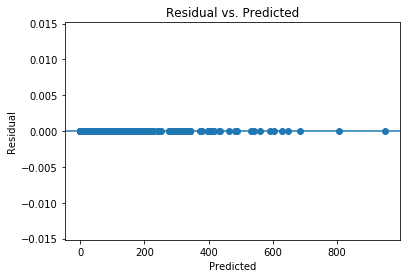

In [234]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**The error terms are still homoscedastic.**

### Low Multicollinearity

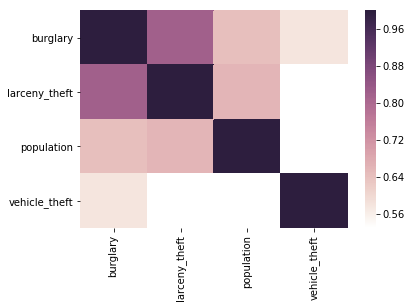

In [235]:
correlation_matrix = X3.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**There's still high collinearity between 'burglary' and 'larceny_theft', but the other features are much less correlated.**

# Model Evaluation: Out-of-Sample

**Data: Crime In New York - [2014](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls/output.xls).**

**Because my finalized model uses 'burglary', 'larceny_theft', 'population', and 'vehicle_theft' to explain 'property_crime', I've used the same features to test out-of-sample prediction of the target.** 

## Cleaning

In [236]:
path = 'C:/Users/missn/Documents/Thinkful/CSV Datasets/Unit 2/Unit 2 Lesson 4/Regression NYC Crime Prediction/NYC Crime 2014.csv'
crime_validation = pd.read_csv('C:/Users/missn/Documents/Thinkful/CSV Datasets/Unit 2/Unit 2 Lesson 4/Regression NYC Crime Prediction/NYC Crime 2014.csv')

In [237]:
pd.options.mode.chained_assignment = None

crime_validation.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson','unknown']
crime_validation.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
pcmodel_validation = crime_validation[['burglary','larceny_theft','population','property_crime','vehicle_theft']]

columns = list(pcmodel_validation.columns)
for column in columns:
    pcmodel_validation[column]=pcmodel_validation[column].str.replace(',','')

features = columns[:1]+columns[3:]
for feature in features:
    pcmodel_validation = pcmodel_validation.apply(pd.to_numeric)
#     pcmodel_validation[feature]=pcmodel_validation[feature].apply(lambda x: 0 if x <= 0 else 1).astype('int64')

pcmodel_validation = pcmodel_validation.dropna()
pcmodel_validation.head()

,burglary,larceny_theft,population,property_crime,vehicle_theft
4,1.0,10.0,1851.0,11.0,0.0
5,1.0,47.0,2568.0,49.0,1.0
6,0.0,1.0,820.0,1.0,0.0
7,0.0,17.0,2842.0,17.0,0.0
8,683.0,3083.0,98595.0,3888.0,122.0


In [238]:
pcmodel_validation.describe()

,burglary,larceny_theft,population,property_crime,vehicle_theft
count,365.000000,365.000000,3.650000e+02,365.000000,365.000000
mean,101.347945,563.739726,3.808991e+04,699.723288,34.635616
std,859.739858,5893.832350,4.435674e+05,7152.724513,409.174707
min,0.000000,0.000000,7.900000e+01,0.000000,0.000000
25%,4.000000,20.000000,2.631000e+03,25.000000,0.000000
50%,12.000000,59.000000,6.548000e+03,75.000000,2.000000
75%,39.000000,228.000000,1.540800e+04,270.000000,6.000000
max,15916.000000,112107.000000,8.473938e+06,135747.000000,7724.000000


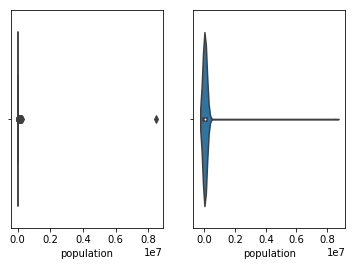

In [239]:
plt.subplot(121)
population = sns.boxplot(pcmodel_validation['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel_validation['population'])

**There are extreme outliers (much more densely populated cities) beyond Q3+1.5IQR that I chose to exclude.**

In [240]:
q25 = pcmodel_validation['population'].quantile(0.25)
q75 = pcmodel_validation['population'].quantile(0.75)
iqr = q75 - q25
max = q75 + (iqr * 1.5)
pcmodel_validation=pcmodel_validation.where(pcmodel_validation['population'] < max)

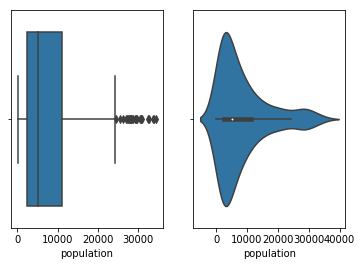

In [241]:
plt.subplot(121)
population = sns.boxplot(pcmodel_validation['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel_validation['population'])

In [242]:
pcmodel_validation.describe()

,burglary,larceny_theft,population,property_crime,vehicle_theft
count,329.000000,329.000000,329.000000,329.000000,329.000000
mean,22.960486,121.006079,8481.495441,147.364742,3.398176
std,37.590399,177.983676,8258.540029,213.732938,6.080466
min,0.000000,0.000000,79.000000,0.000000,0.000000
25%,3.000000,17.000000,2460.000000,21.000000,0.000000
50%,10.000000,47.000000,5234.000000,61.000000,1.000000
75%,26.000000,149.000000,11231.000000,169.000000,4.000000
max,354.000000,1317.000000,34463.000000,1401.000000,59.000000


## Cross-Validation

In [243]:
lfv = 'property_crime ~ burglary + larceny_theft + population + vehicle_theft'
lmv = smf.ols(formula=lfv, data=pcmodel_validation).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.137e+30
Date:                Sun, 25 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:42:24   Log-Likelihood:                 7141.2
No. Observations:                 274   AIC:                        -1.427e+04
Df Residuals:                     269   BIC:                        -1.425e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.304e-13   1.15e-13      1.134

In [245]:
pcmodel_validation = pcmodel_validation.dropna()
X_test = pcmodel_validation[['burglary','larceny_theft','population','vehicle_theft']]
y_test = pcmodel_validation['property_crime']
lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X_test, y_test, cv=10)
scores = cross_val_score(lr, X_test, y_test)*100
print("Mean Accuracy & Confidence Interval: {:.2f}% (+/- {:.2f}%).".format(scores.mean(), scores.std()))

Mean Accuracy & Confidence Interval: 100.00% (+/- 0.00%).


**The overall model is more valuable than the intercept-only fit, all of the features are statistically significant, and the R^2 is stable.**